In [ ]:
!pip install fredapi > /dev/null

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

from google.colab import userdata
fred_key = userdata.get('fred-api')

# 1. Create the Fred Object

In [ ]:
fred = Fred(api_key=fred_key)

# 2. Search for economic data

In [ ]:
sp_search = fred.search('S&P', order_by='popularity')

In [ ]:
sp_search.shape

(1000, 15)

# 3.Pull Raw Data & Plot

<Axes: title={'center': 'S&P 500'}>

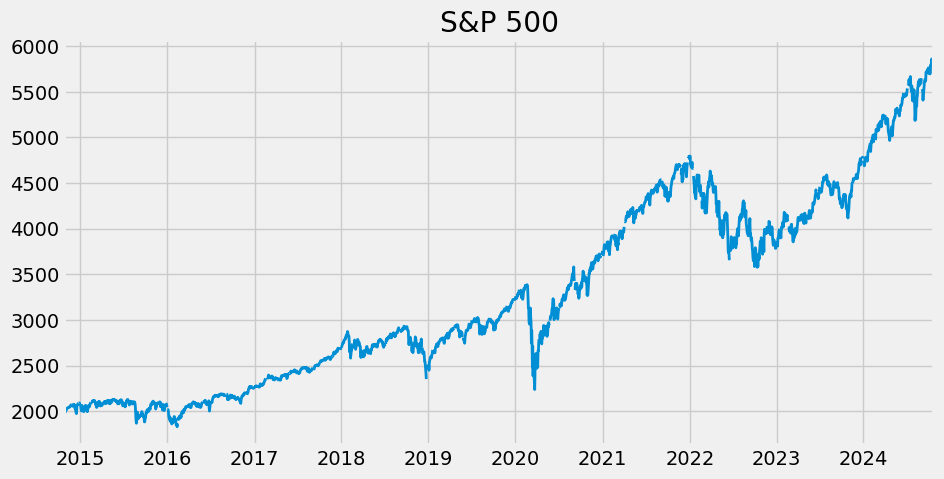

In [ ]:
sp500 = fred.get_series(series_id="SP500")
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)

# 4. Pull and Join Multiple Data Series

In [ ]:
uemp_results = fred.search('unemployment')

In [ ]:
unrate = fred.get_series('UNRATE')

In [ ]:
# unrate.plot()

In [ ]:
unemp_df = fred.search('unemployment rate state', filter=('frequency', 'Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [ ]:
all_results = []

for myid in unemp_df.index:
  results = fred.get_series(myid)
  results = results.to_frame(name=myid)
  all_results.append(results)

uemp_results = pd.concat(all_results, axis=1)

In [ ]:
cols_to_drop = []
for i in uemp_results:
  if len(i) > 4:
    cols_to_drop.append(i)


uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1).dropna()

In [ ]:
uemp_states = uemp_results.copy()
uemp_staes = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [ ]:
# Plot States Unemployment Rate
px.line(uemp_states)

## Pull April 2020 Unemployment Rate Per State

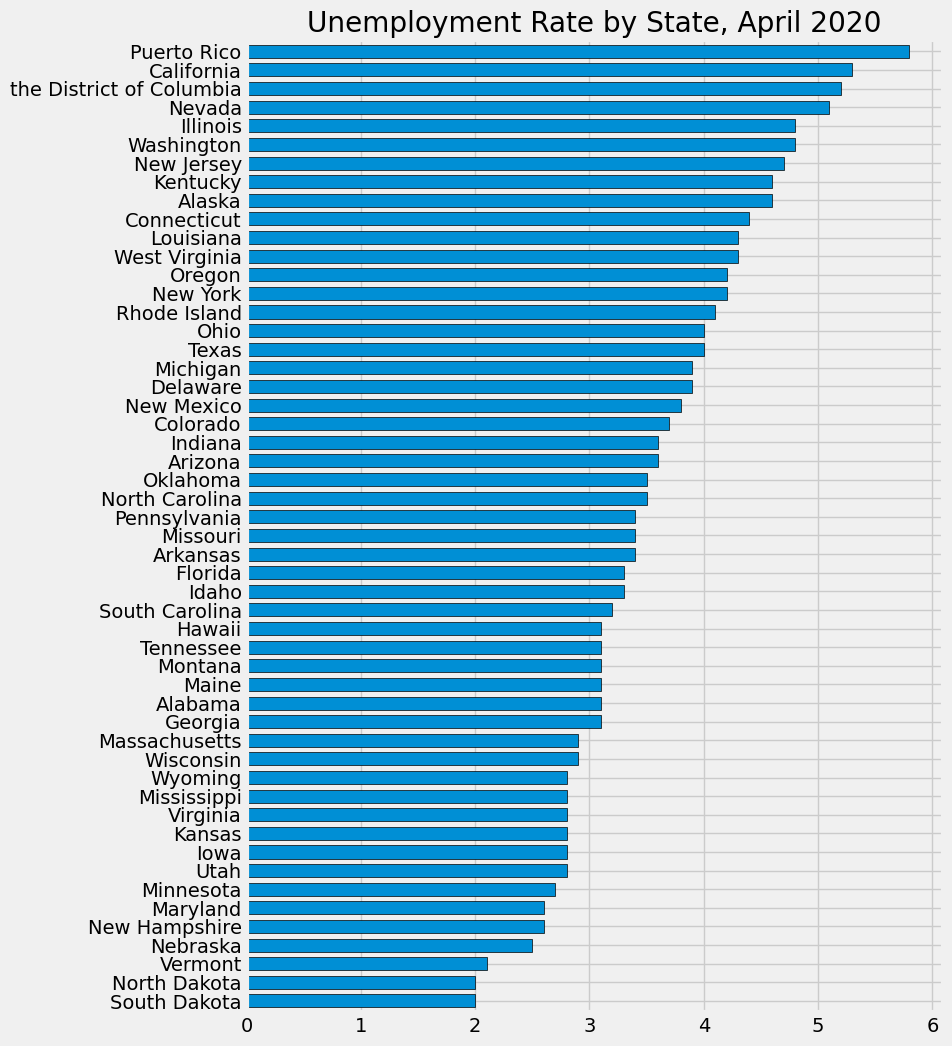

In [ ]:
ax = uemp_states.loc[uemp_states.index == '2024-04-01'].T \
    .sort_values('2024-04-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title="Unemployment Rate by State, April 2020")
ax.legend().remove()
plt.show()

# Pull Participation Rate

In [ ]:
part_df = fred.search('participation rate state', filter=('frequency', 'Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [ ]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

# Plot Unemployment vs Participation for each state!

In [ ]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

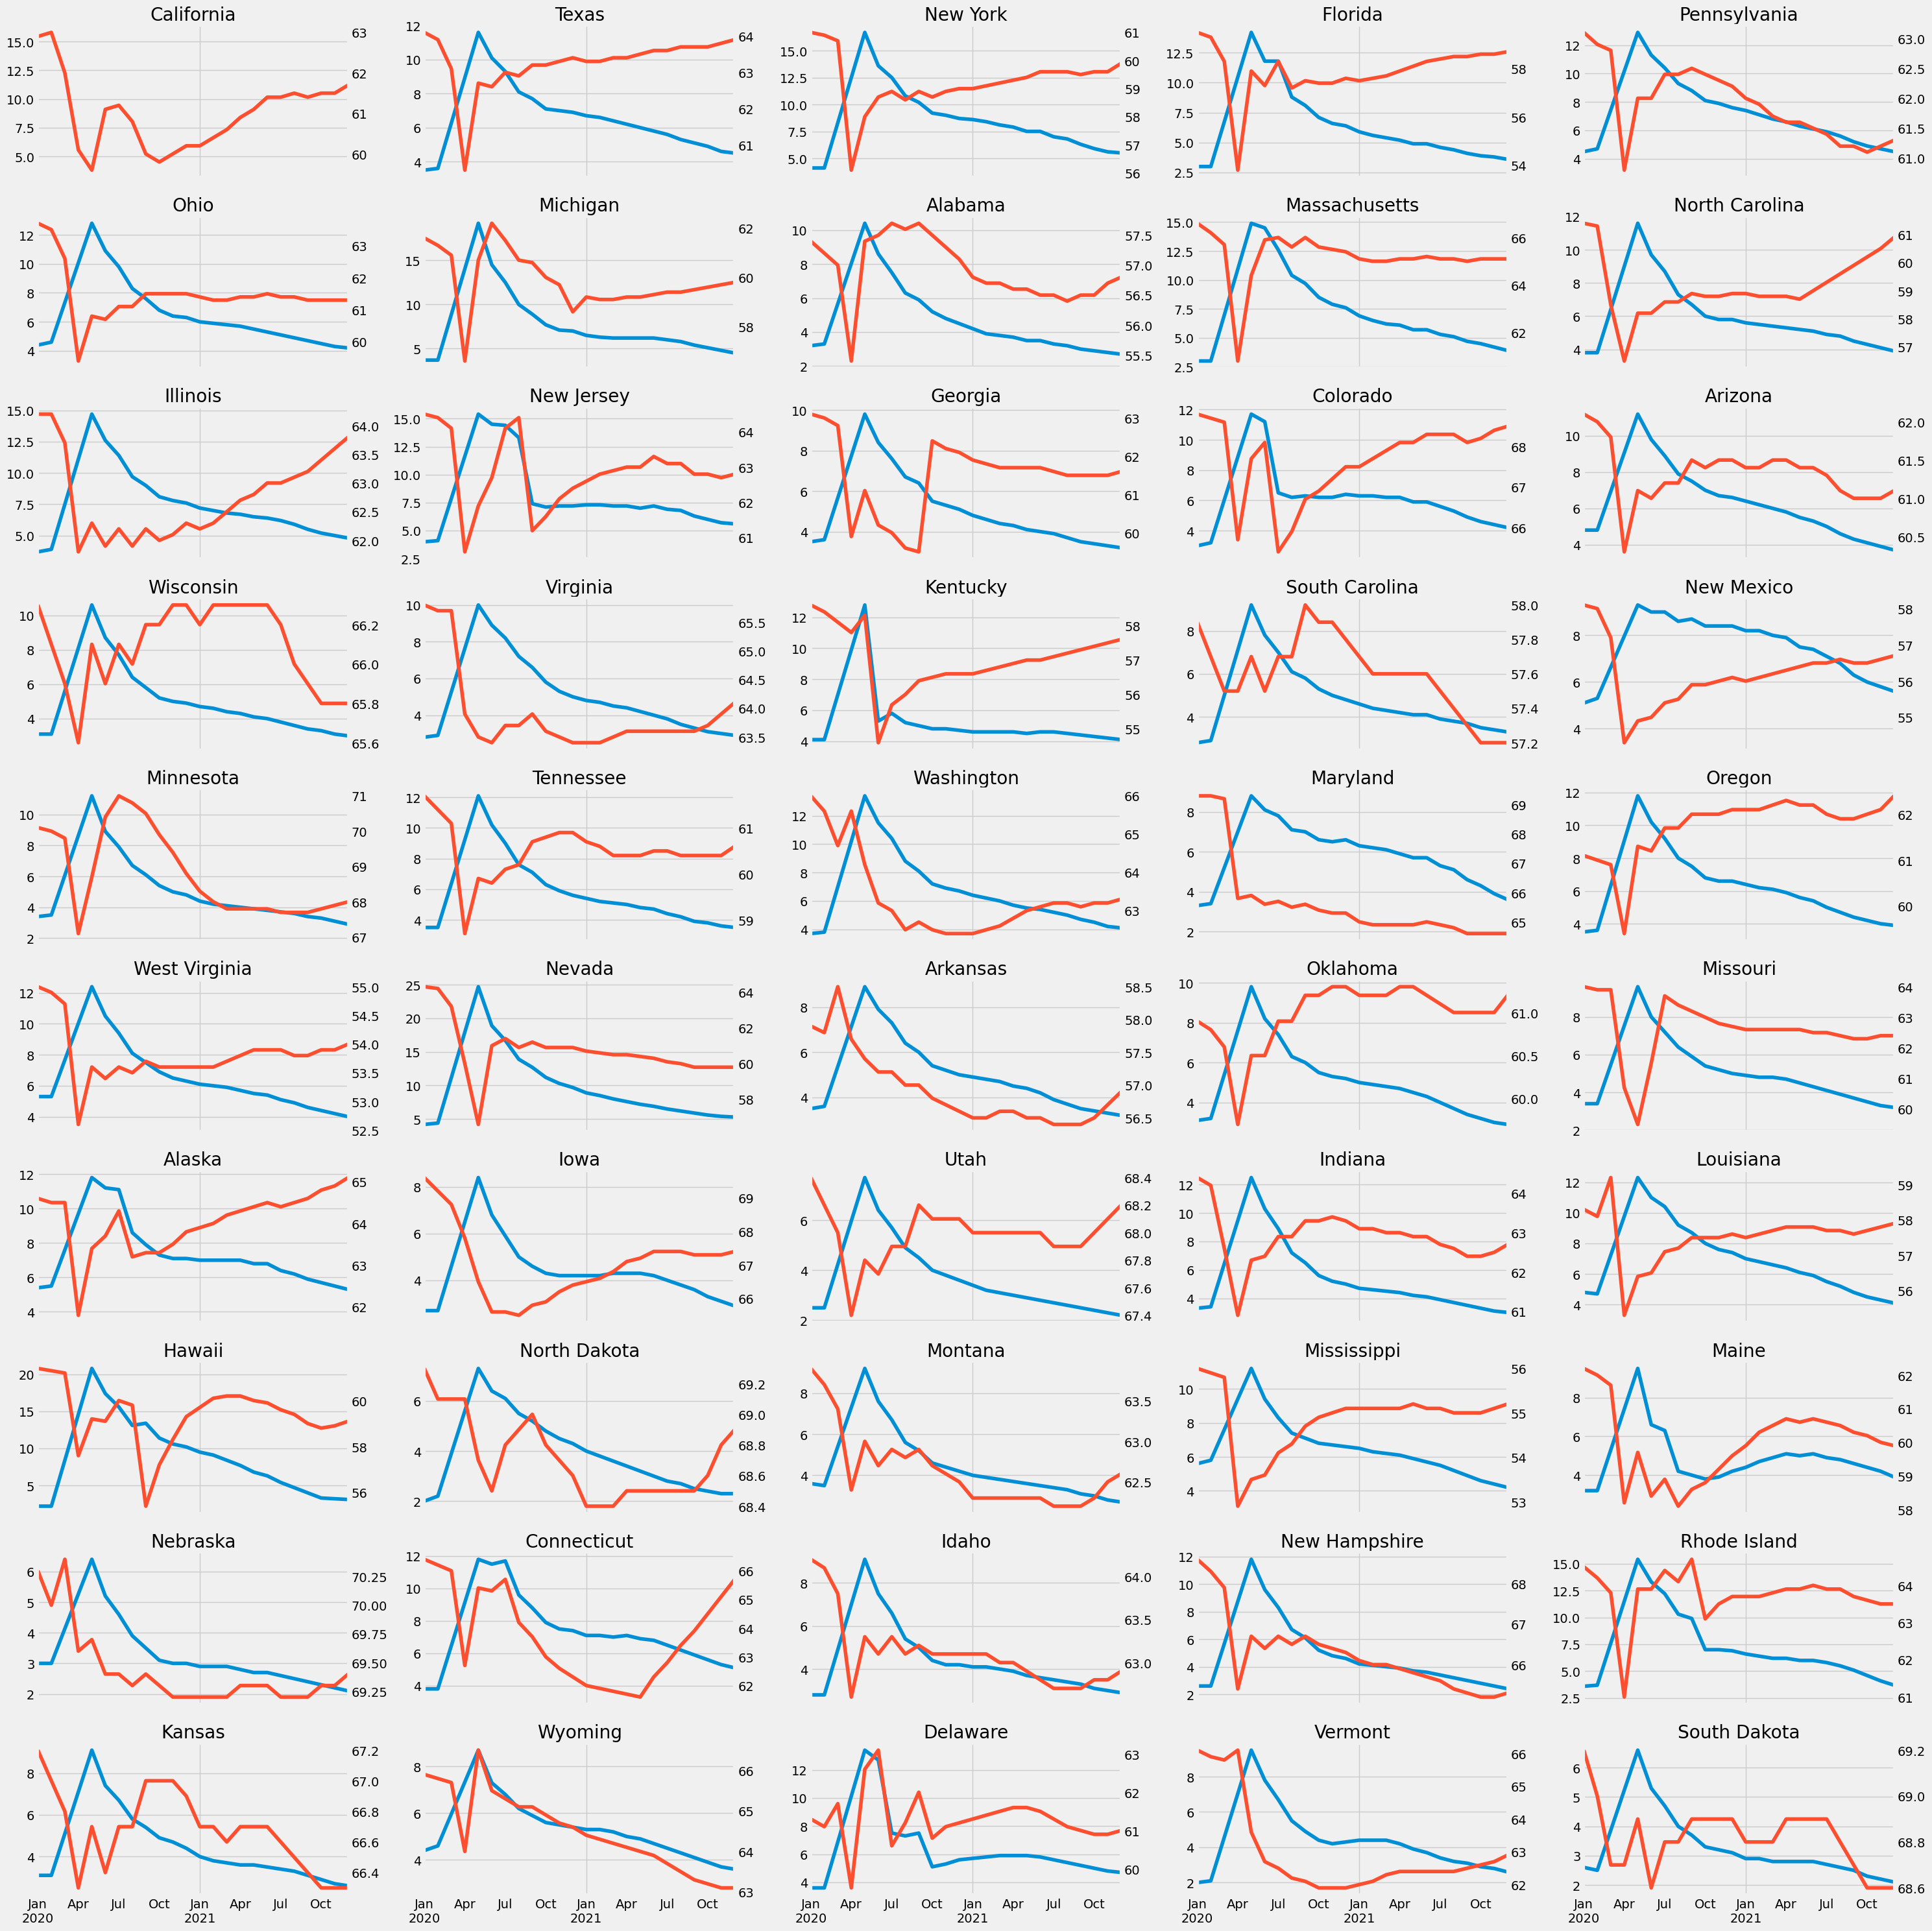

In [ ]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2024')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

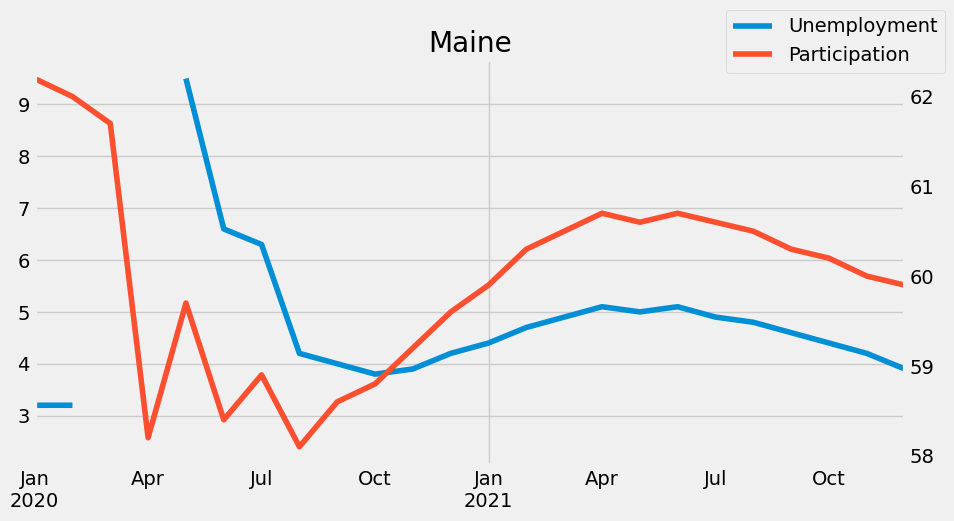

In [ ]:
state = 'Maine'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = uemp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2020 and index < 2024')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2022')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()